# Imports

In [1]:
import pandas as pd
from funciones_analisis import detectar_drift_ks, _drift_blocks, plot_ks_gallery, plot_ks_one, merge_blocks, plot_raw_with_drift

# Lectura

In [2]:
# Leer los tres dataframes procesados desde la carpeta 'df_procesados'
df_planta_1 = pd.read_csv('../df_procesados/df_planta_1.csv')
df_planta_2 = pd.read_csv('../df_procesados/df_planta_2.csv')
df_planta_3 = pd.read_csv('../df_procesados/df_planta_3.csv')

In [3]:
df_planta_1['date_time'] = pd.to_datetime(df_planta_1['date_time'])
df_planta_2['date_time'] = pd.to_datetime(df_planta_2['date_time'])
df_planta_3['date_time'] = pd.to_datetime(df_planta_3['date_time'])

# Planta 1

In [4]:
sensores = [
    c for c in df_planta_1.select_dtypes('number').columns
    if c not in {"planta1_activa"}  # excluye flags si existen
]


# --- GENERAL (sin filtrar) ---
res_general = detectar_drift_ks(
    df_planta_1,
    columnas=sensores,
    window_days=1, step_days=1,
    min_dias=1,  min_points=800,
    compare="adjacent",
    skip_first_days=2,
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=2,
    winsor=(0.01, 0.99)
)

# --- SOLO ACTIVA ---
res_act = detectar_drift_ks(
    df_planta_1,
    columnas=sensores,
    flag_col="planta1_activa", flag_value=True,  # o 1 si la guardaste como 0/1
    window_days=1, step_days=1,
    min_dias=1,  min_points=800,  # si activa tiene muuuchos datos, deja igual
    compare="adjacent",
    skip_first_days=2,
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=2,
    winsor=(0.01, 0.99)
)

# --- SOLO INACTIVA ---
res_inact = detectar_drift_ks(
    df_planta_1,
    columnas=sensores,
    flag_col="planta1_activa", flag_value=False,  # o 0
    window_days=1, step_days=1,
    min_dias=1,  min_points=600,  # suele haber menos puntos; ajusta si quieres
    compare="adjacent",
    skip_first_days=2,
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=2,
    winsor=(0.01, 0.99)
)


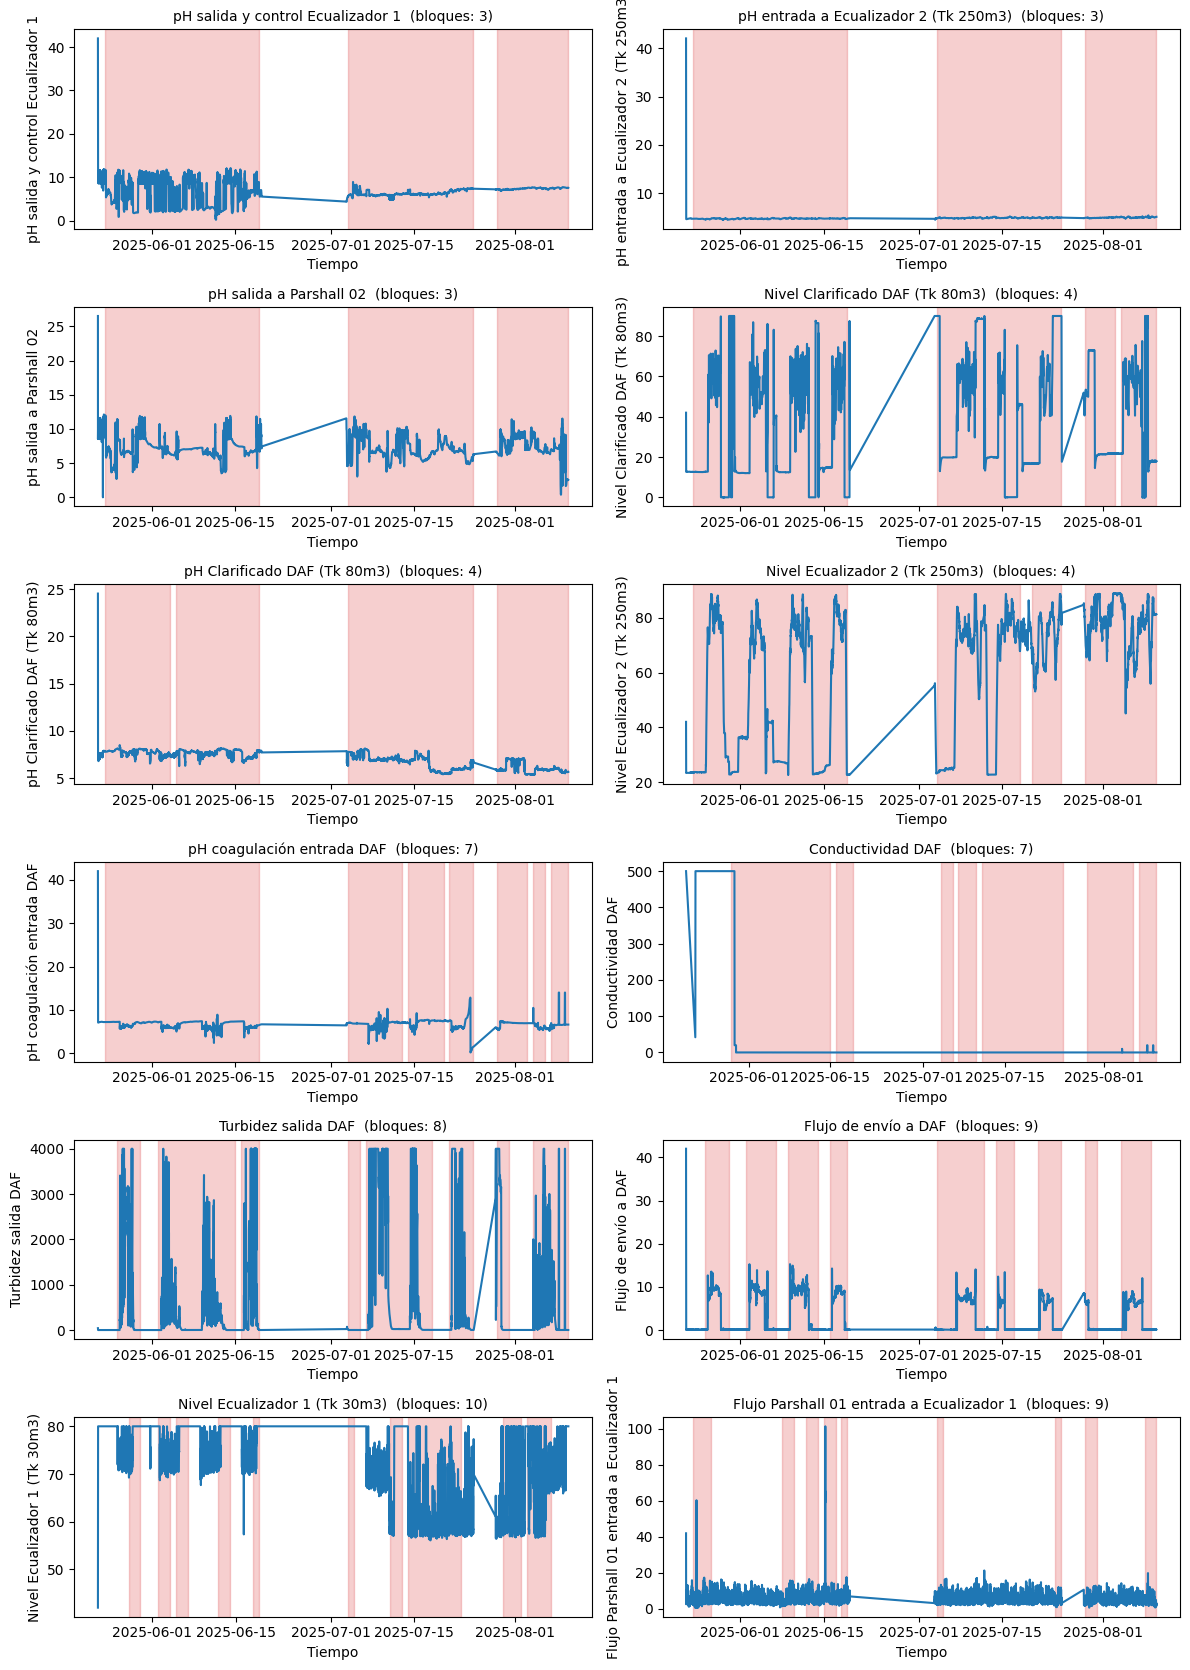

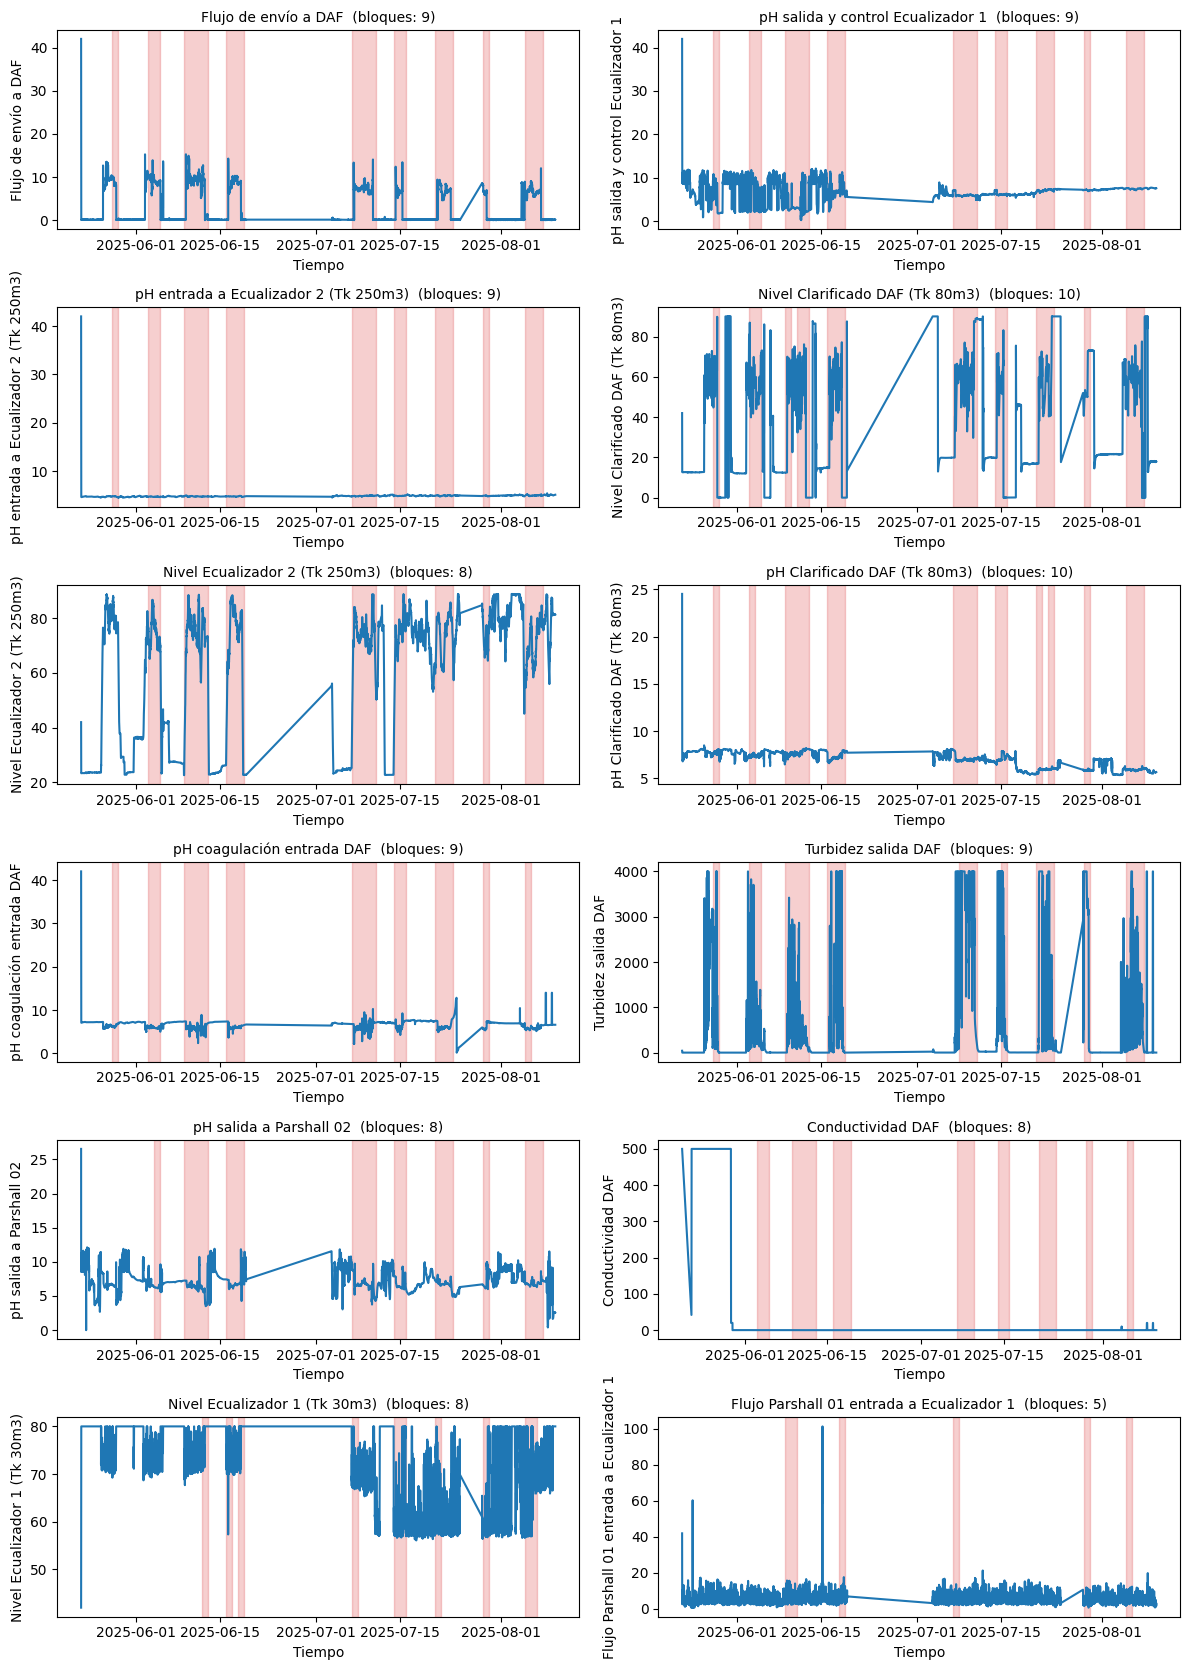

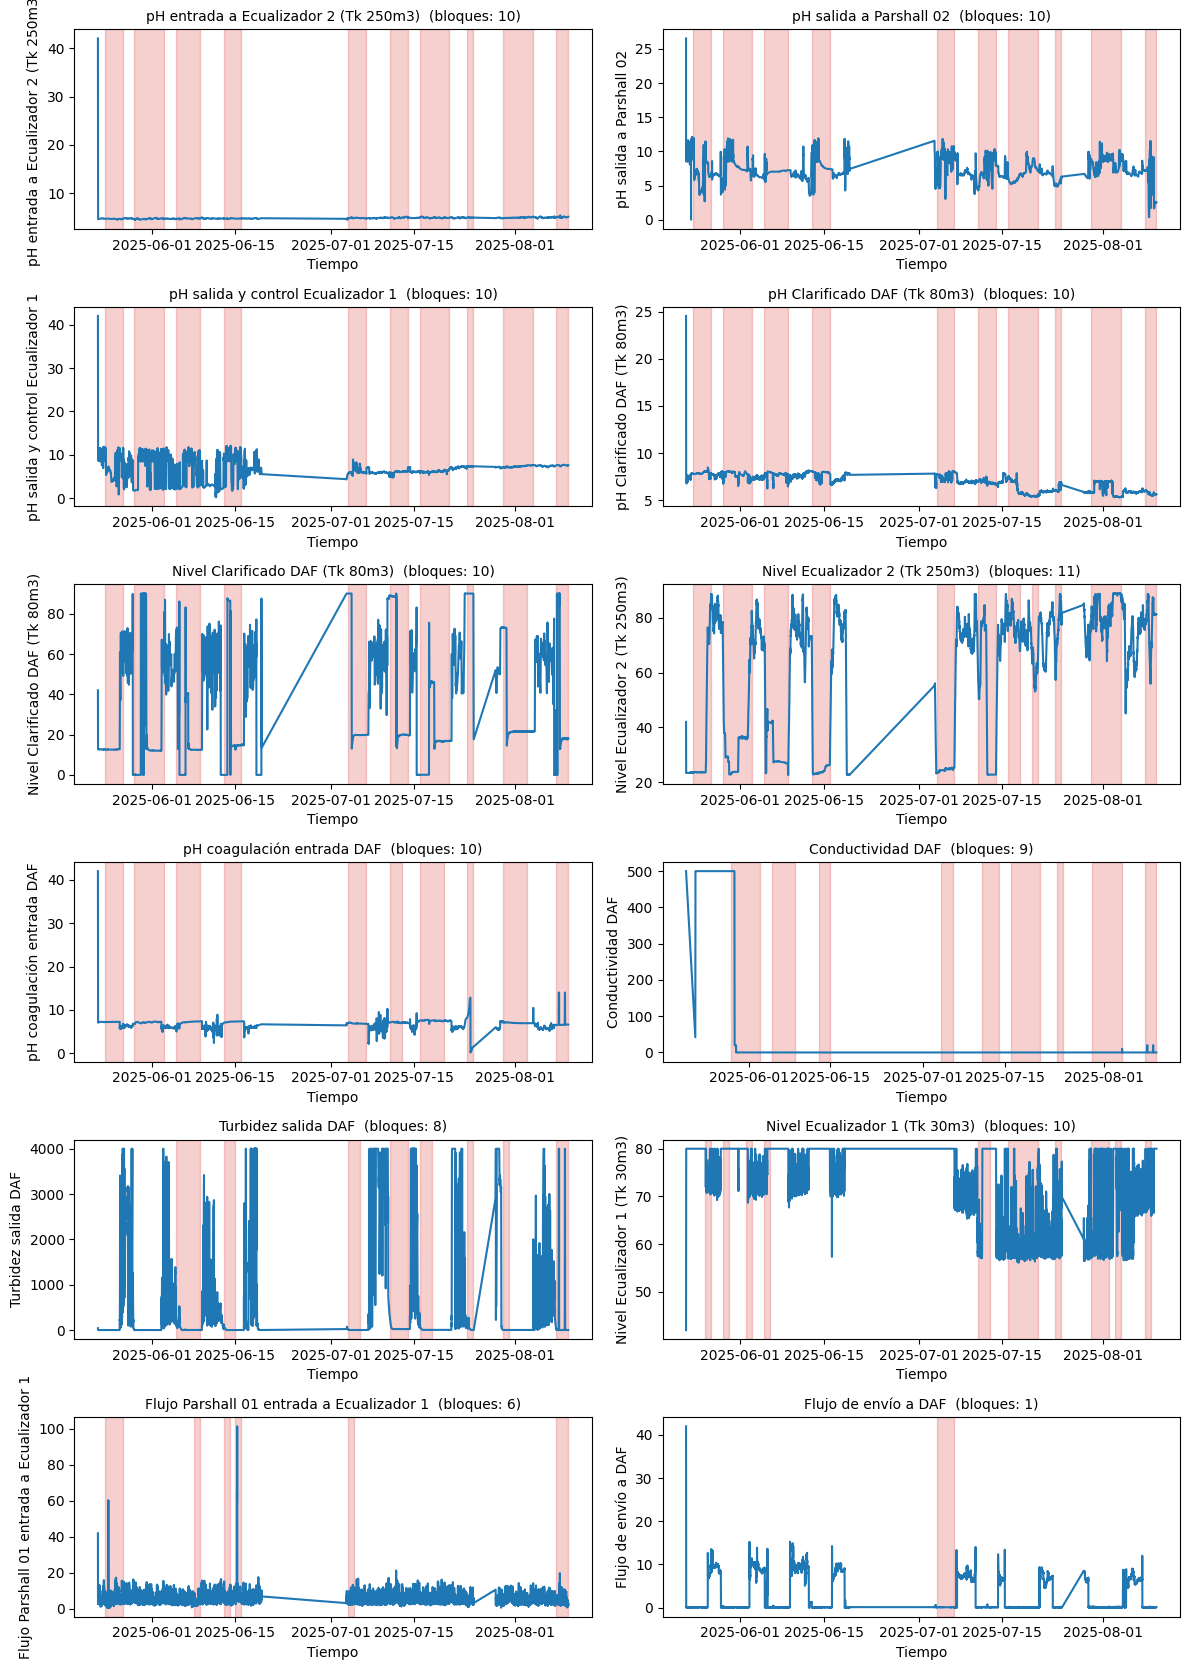

In [5]:
res_all = pd.concat([res_general, res_act, res_inact], ignore_index=True)

# Galería SOLO con drift detectado, como antes:
plot_ks_gallery(df_planta_1, res_general, "date_time", resample="10min", ncols=2, height_per_row=2.8, only_with_drift=True)
plot_ks_gallery(df_planta_1, res_act,     "date_time", resample="10min", ncols=2, height_per_row=2.8, only_with_drift=True)
plot_ks_gallery(df_planta_1, res_inact,   "date_time", resample="10min", ncols=2, height_per_row=2.8, only_with_drift=True)


## Ventanas de Proceso Activo

In [6]:
def blocks_from_flag(df, flag_col="planta1_activa", fecha_col="date_time"):
    df = df.copy()
    df[fecha_col] = pd.to_datetime(df[fecha_col])
    df = df.sort_values(fecha_col)

    blocks = []
    in_block = False
    start = None

    for t, f in zip(df[fecha_col], df[flag_col]):
        if f and not in_block:
            # comienza bloque
            in_block = True
            start = t
        elif not f and in_block:
            # termina bloque
            in_block = False
            blocks.append((start, t))
            start = None

    if in_block:
        blocks.append((start, df[fecha_col].iloc[-1]))

    return blocks

c:\Users\frncc\OneDrive - Universidad Católica de Chile\Desktop\UC\2025-2\Proyecto de Grado\Proyecto-Grado\Analisis\funciones_analisis.py:481: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  plt.xlabel("Tiempo"); plt.ylabel(var); plt.tight_layout(); plt.show()
c:\Users\frncc\OneDrive - Universidad Católica de Chile\Desktop\UC\2025-2\Proyecto de Grado\Proyecto-Grado\Analisis\funciones_analisis.py:481: UserWarning: Glyph 22359 (\N{CJK UNIFIED IDEOGRAPH-5757}) missing from font(s) DejaVu Sans.
  plt.xlabel("Tiempo"); plt.ylabel(var); plt.tight_layout(); plt.show()
c:\Users\frncc\OneDrive - Universidad Católica de Chile\Desktop\UC\2025-2\Proyecto de Grado\Proyecto-Grado\Analisis\funciones_analisis.py:481: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  plt.xlabel("Tiempo"); plt.ylabel(var); plt.tight_layout(); plt.show()
c:\Users\frncc\OneDrive - Universidad Católica de Chile\Desktop\UC\2025-2\Proye

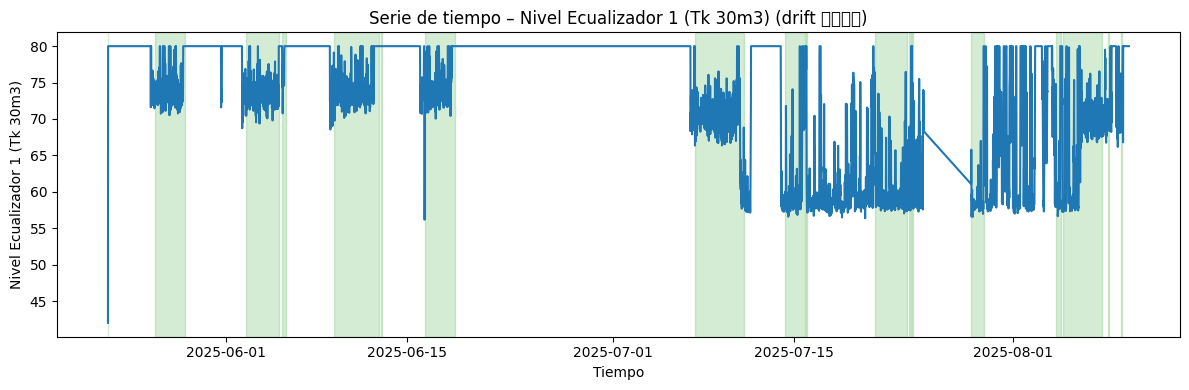

In [7]:
blocks = blocks_from_flag(df_planta_1, flag_col="planta1_activa", fecha_col="date_time")

plot_raw_with_drift(
    df_planta_1, 
    fecha_col="date_time", 
    var="Nivel Ecualizador 1 (Tk 30m3)", 
    blocks=blocks,
    resample="15min",   # o None
    color="tab:green", 
    alpha=0.2
)

# Planta 2

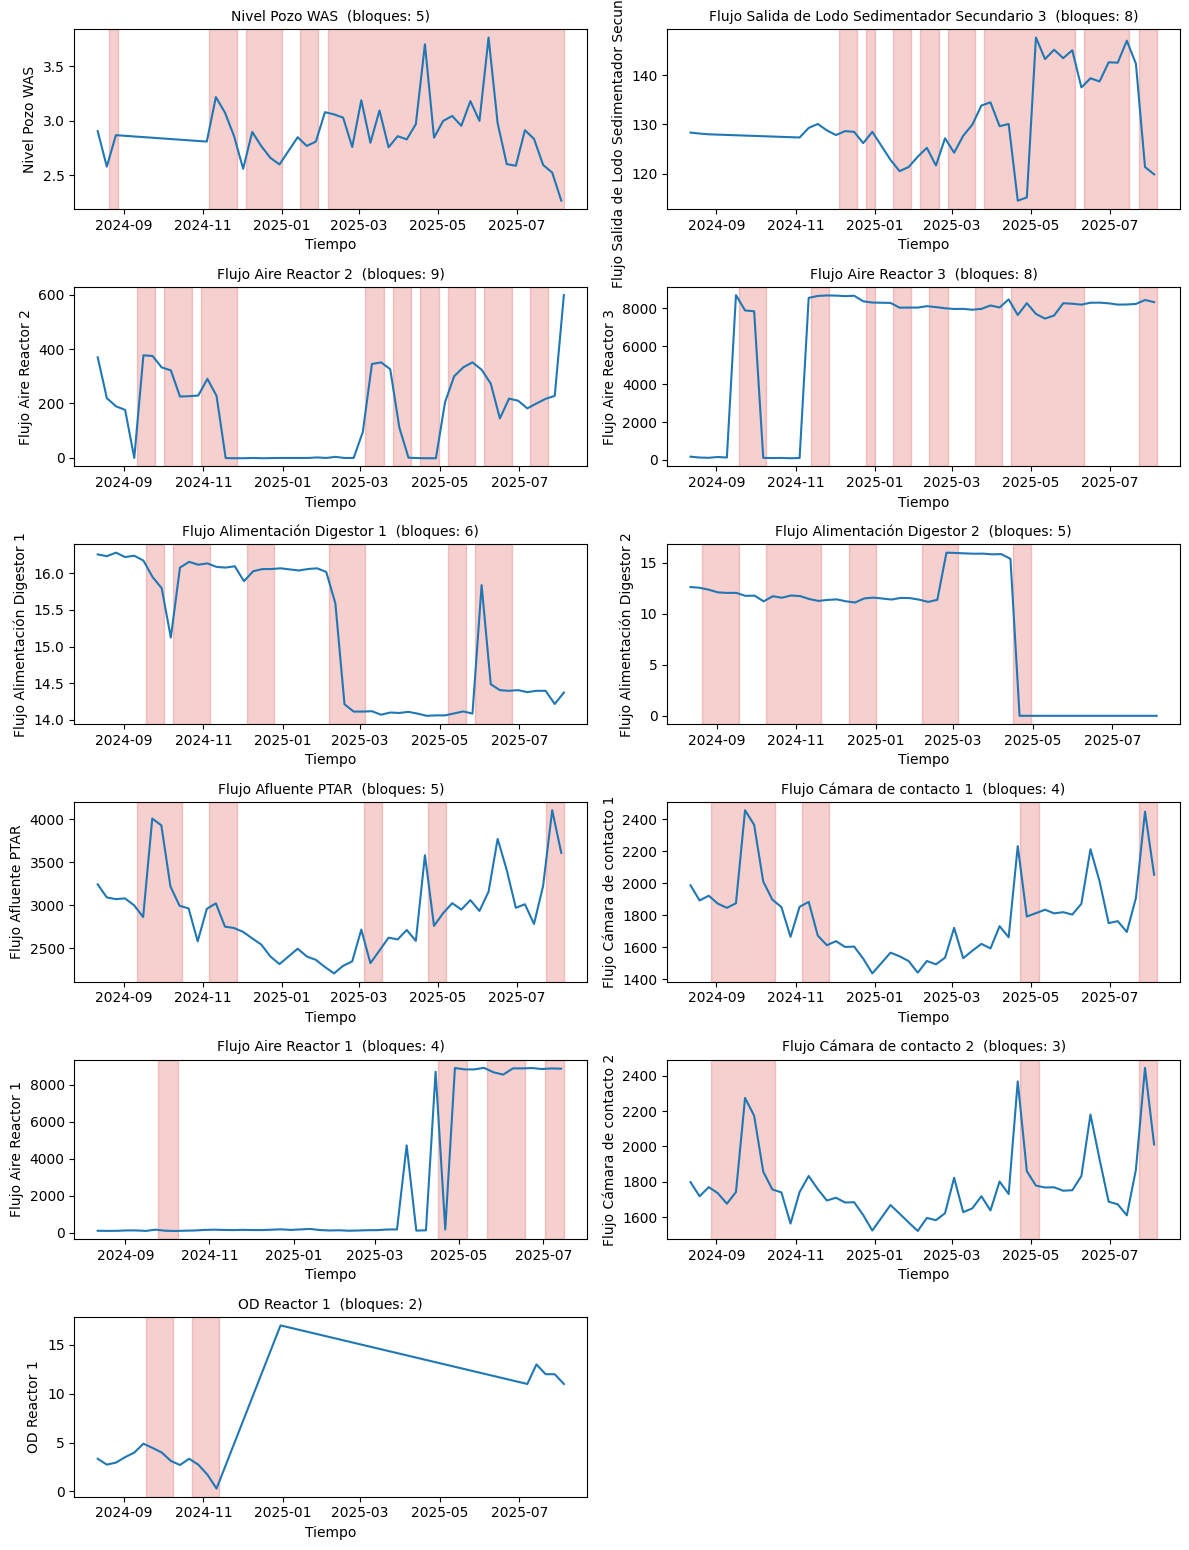

In [8]:
cols2 = df_planta_2.select_dtypes('number').columns.tolist()

res2 = detectar_drift_ks(
    df_planta_2, columnas=cols2,
    window_days=7, step_days=7,   # semanal, sin solape
    min_dias=5, min_points=1200,  # ~200 pts/día * 5 días
    compare="adjacent",
    skip_first_days=2,
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=2,
    winsor=(0.01, 0.99)
)

# visual semanal
plot_ks_gallery(df_planta_2, res2, "date_time", resample="7D", ncols=2)


In [16]:
"""for var in cols2:
    plot_ks_one(
        df=df_planta_2,
        res=res2,
        fecha_col="date_time",
        var=var,
        resample="7D",           # acorde al análisis semanal
        shade_color="tab:red",
        shade_alpha=0.25,
        line_kwargs={"linewidth": 1.1}
    )"""

'for var in cols2:\n    plot_ks_one(\n        df=df_planta_2,\n        res=res2,\n        fecha_col="date_time",\n        var=var,\n        resample="7D",           # acorde al análisis semanal\n        shade_color="tab:red",\n        shade_alpha=0.25,\n        line_kwargs={"linewidth": 1.1}\n    )'

# Planta 3

In [ ]:
cols3 = df_planta_3.select_dtypes('number').columns.tolist()

res3 = detectar_drift_ks(
    df_planta_3, columnas=cols3,
    window_days=7, step_days=7,
    min_dias=5, min_points=7000,  # ~1.4k pts/día * 5 días ≈ 7k
    compare="adjacent",
    skip_first_days=1,            # evita sesgo del arranque sin perder ventanas
    alpha=0.005, ks_min=0.15,
    fdr=True, min_consecutive=1,  # clave por horizonte corto
    winsor=(0.01, 0.99)
)

plot_ks_gallery(df_planta_3, res3, "date_time", resample="7D", ncols=2)


No hay variables con drift para mostrar.
